In [1]:
#https://filterpy.readthedocs.io/en/latest/
try:
    import lcapy
except ModuleNotFoundError:
    print("Could not find lcapy - installing")
    !pip install lcapy
  
from lcapy import Circuit, j, omega, s, exp, sign
from lcapy import R, C, L
from lcapy import *

import numpy as np
from numpy import logspace

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, savefig

%matplotlib inline

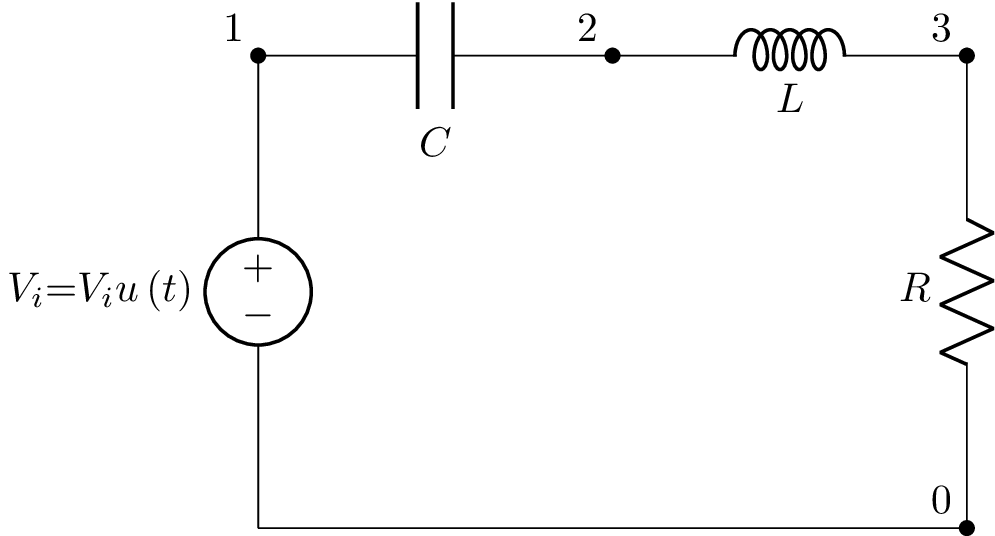

In [2]:
R = 200
cct = Circuit("""
Vi 1 0_1 step; down=2
C 1 2 ; right=1.5
L 2 3 ; right=1.5
R 3 0 ; down
W 0_1 0; right""".format(R = R))
cct.draw()

Show Ways to Manipulate the Transfer Function

In [3]:
H = (cct.R.V(s) / cct.Vi.V(s)).simplify(); H

      C⋅R⋅s       
──────────────────
     2            
C⋅L⋅s  + C⋅R⋅s + 1

In [4]:
H(j * omega)

       ⅉ⋅C⋅R⋅ω        
──────────────────────
       2              
- C⋅L⋅ω  + ⅉ⋅C⋅R⋅ω + 1

In [5]:
H(j * omega).rationalize_denominator()

 2  2  2           ⎛       2    ⎞
C ⋅R ⋅ω  + ⅉ⋅C⋅R⋅ω⋅⎝- C⋅L⋅ω  + 1⎠
─────────────────────────────────
                            2    
      2  2  2   ⎛     2    ⎞     
     C ⋅R ⋅ω  + ⎝C⋅L⋅ω  - 1⎠     

In [6]:
H(j * omega).real_imag

         2  2  2                     ⎛     2    ⎞  
        C ⋅R ⋅ω              ⅉ⋅C⋅R⋅ω⋅⎝C⋅L⋅ω  - 1⎠  
──────────────────────── - ────────────────────────
                       2                          2
 2  2  2   ⎛     2    ⎞     2  2  2   ⎛     2    ⎞ 
C ⋅R ⋅ω  + ⎝C⋅L⋅ω  - 1⎠    C ⋅R ⋅ω  + ⎝C⋅L⋅ω  - 1⎠ 

In [7]:
H(j * omega).magnitude


           C⋅R⋅│ω│            
──────────────────────────────
    __________________________
   ╱                        2 
  ╱   2  2  2   ⎛     2    ⎞  
╲╱   C ⋅R ⋅ω  + ⎝C⋅L⋅ω  - 1⎠  

In [8]:
H(j * omega).phase_degrees

         ⎛       2           ⎞
180⋅atan2⎝- C⋅L⋅ω  + 1, C⋅R⋅ω⎠
──────────────────────────────
              π               

In [9]:
H1 = H.subs('C', 1e-6).subs('R', 1e3).subs('L', 1e-3)
H1(j * omega)

             ⅉ⋅ω              
──────────────────────────────
     ⎛       2               ⎞
     ⎜      ω        ⅉ⋅ω     ⎟
1000⋅⎜- ────────── + ──── + 1⎟
     ⎝  1000000000   1000    ⎠

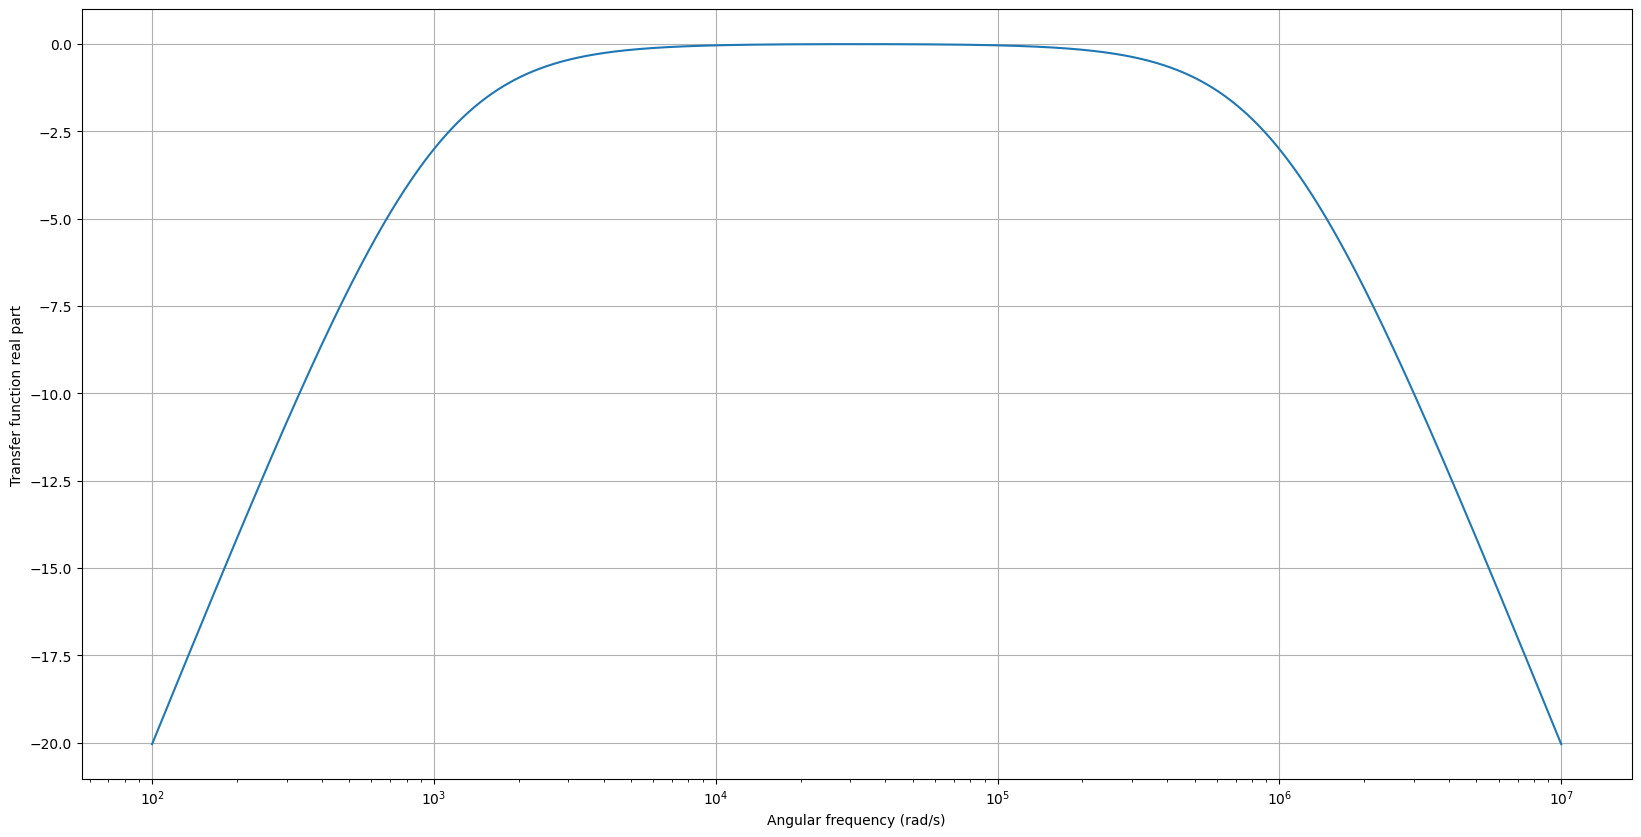

In [10]:
w = logspace(2, 7, 1500)
ax = H1(j * omega).dB.plot(w, log_frequency=True)

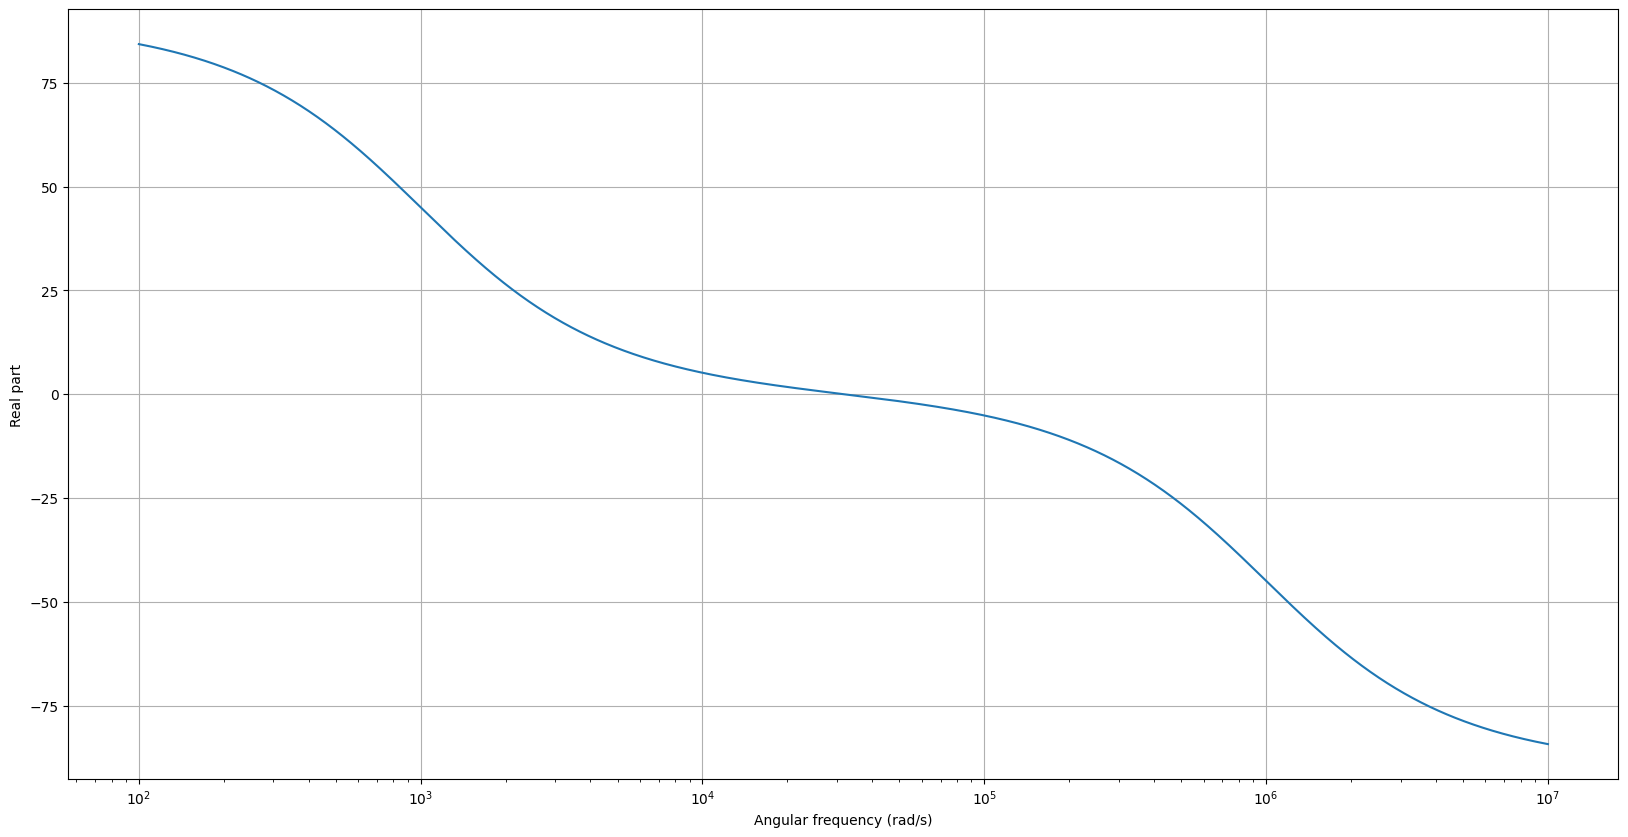

In [11]:
ax = H1(j * omega).phase_degrees.plot(w, log_frequency=True)

Solve for Time Response

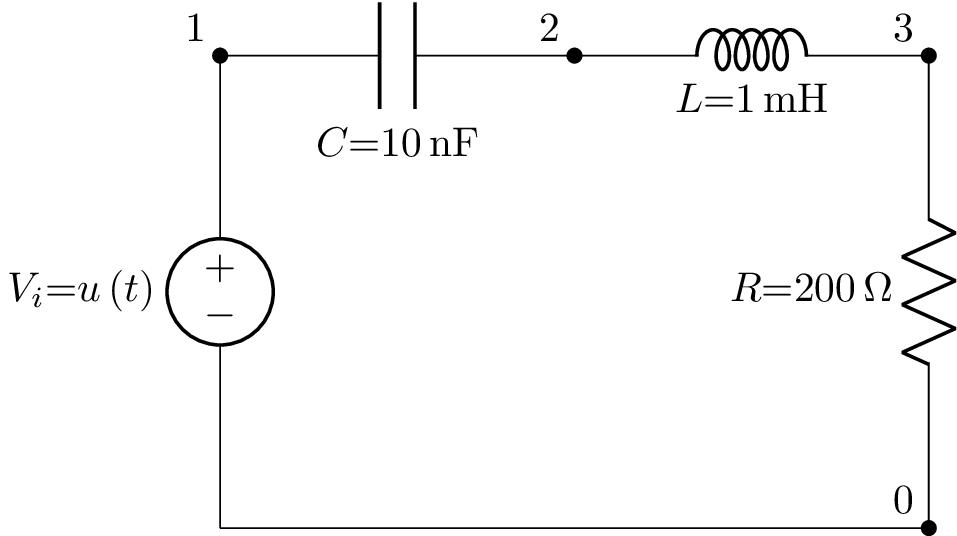

In [12]:
cct2 = Circuit("""
Vi 1 0_1 step 1; down=2
C 1 2 1e-8; right=1.5
L 2 3 1e-3; right=1.5
R 3 0 {R}; down
W 0_1 0; right""".format(R = R))
cct2.draw()

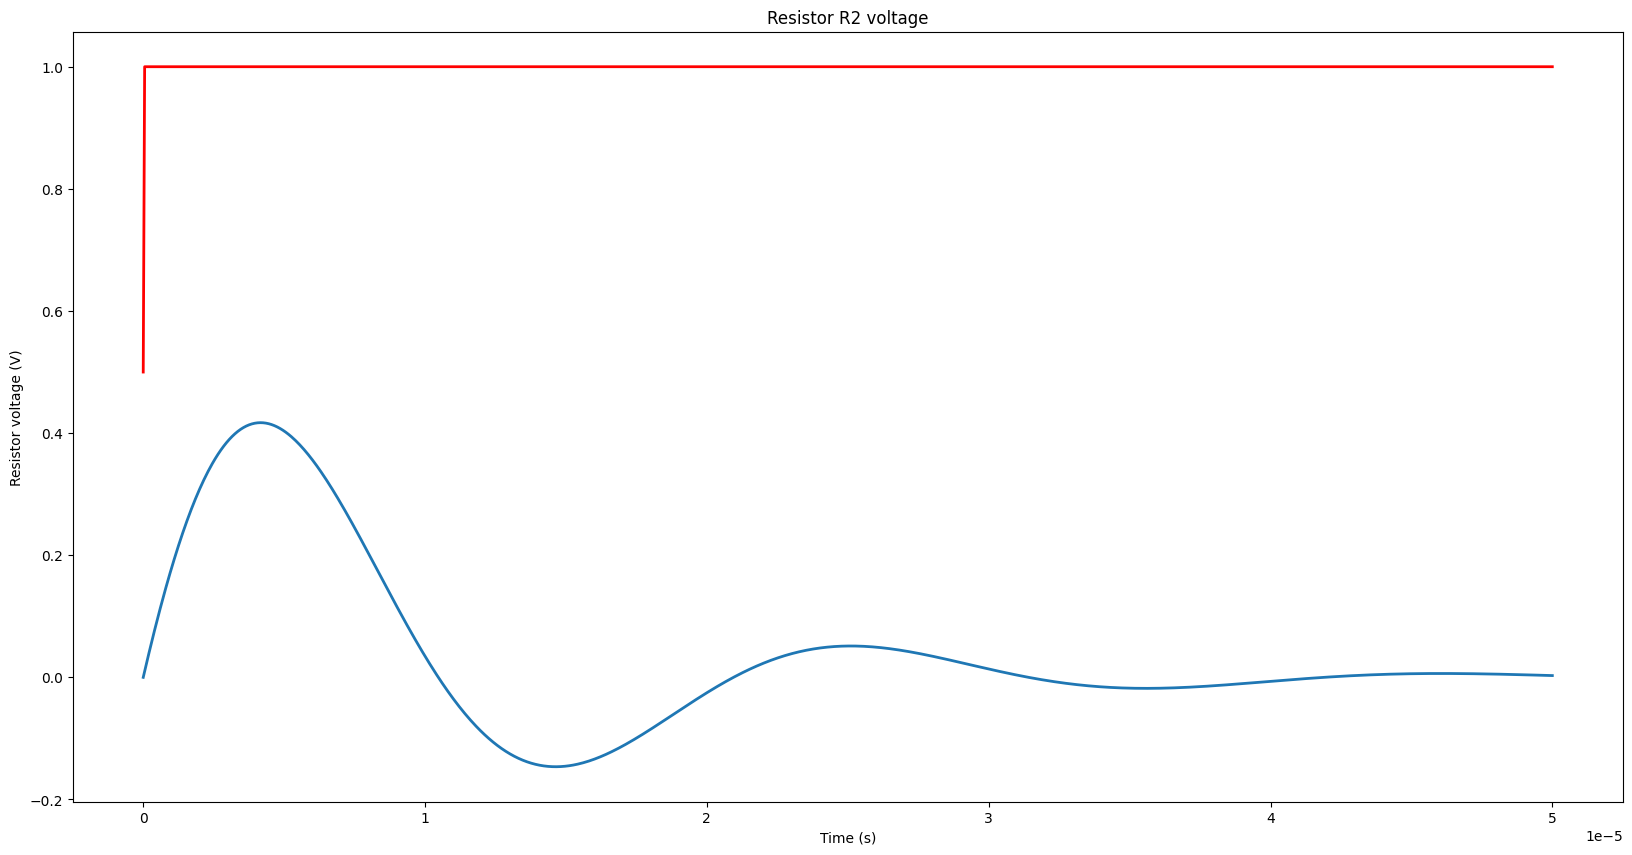

In [13]:
t = np.linspace(0, .00005, 1000)
fig = figure()
ax = fig.add_subplot(111, title='Resistor R2 voltage')
ax.plot(t, cct2.R.v.evaluate(t), linewidth=2)
ax.plot(t, cct2.Vi.v.evaluate(t), linewidth=2, color='red')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');
ax.grid()

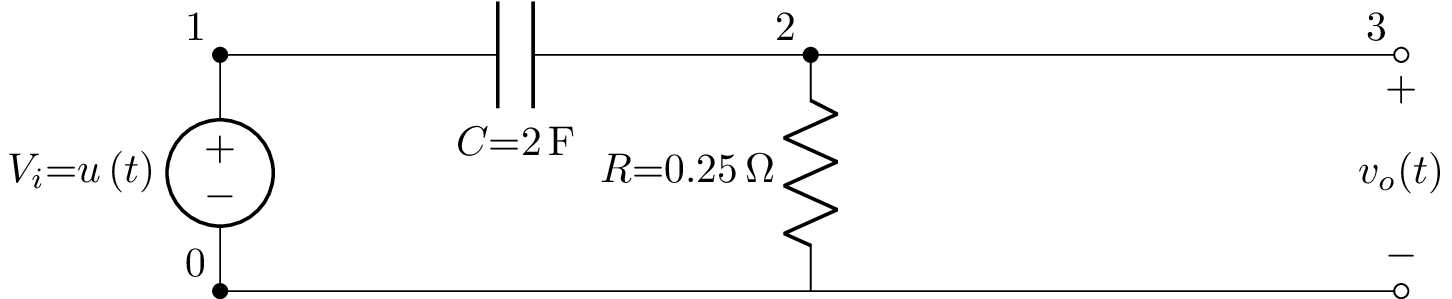

In [14]:
a = Circuit("""
Vi 1 0 step 1; down
C 1 2 2; right=2.5
R 2 0_2 {1/4}; down
W 0 0_2; right
W 2 3; right=2.5
W 0_2 0_3; right
P2 3 0_3; down, v^=v_o(t)""")
a.draw()


In [15]:
H = (a.R.V(s) / a.Vi.V(s)).simplify(); H

  s  
─────
s + 2

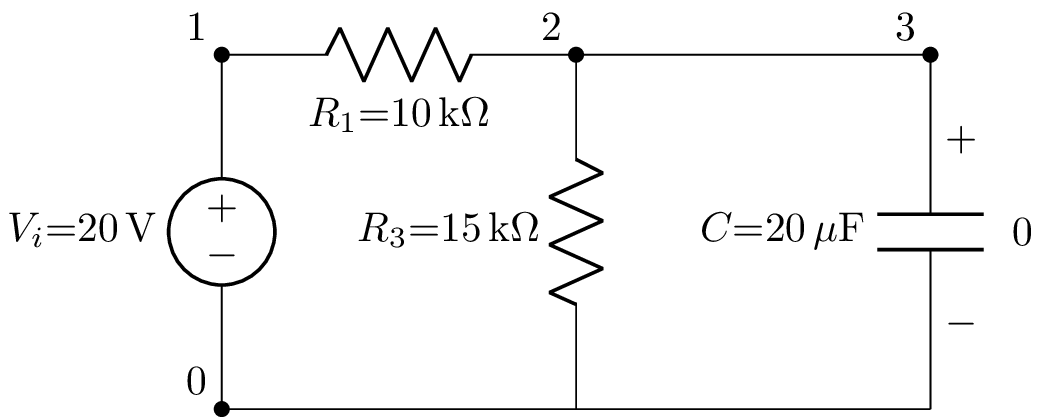

0


In [16]:
from lcapy import exp,t 

#w = exp(-1* t) * u(t)
RR3 = 15*10**3
RR1 = 8/(12/RR3)
CC = 20*10**(-6)
w = 20

cct6 = Circuit("""
Vi 1 0 ; down=1.5
R1 1 2 ; right=1.5
R3 2 0_2 ; down=1.5
W 2 3; right=1.5
C 3 0_3 C 0; down=1.5, , v=0
W 0 0_2; right
W 0_2 0_3; right""")
cct6a = cct6.subs({'Vi':w, 'R1': RR1, 'C':CC, 'R3':RR3})

cct6a.draw()
print(cct6a.C.v(0))

In [17]:
cct6a.C.v

         -250000000000000000⋅t            
         ──────────────────────           
           29999999999999997              
12 - 12⋅ℯ                        for t ≥ 0

0.11999999999999997


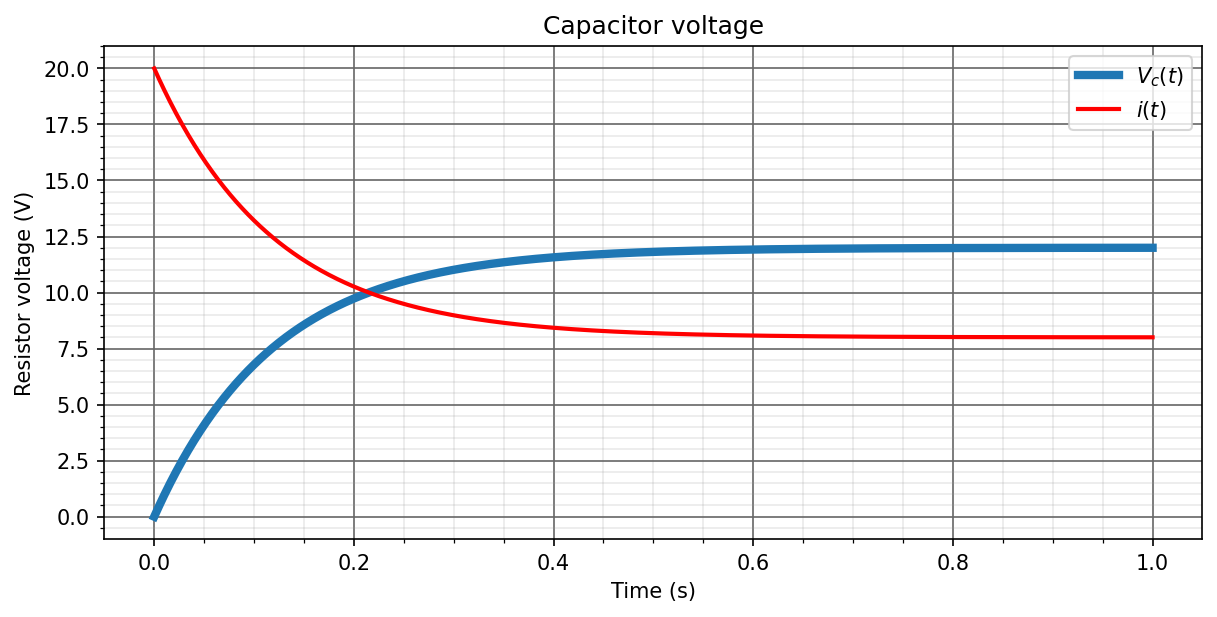

In [18]:
t = np.linspace(0, 1, 1000)
vc = cct6a.C.v.evaluate(t)
vr = cct6a.R1.v.evaluate(t)

Req = 1/(1/RR1+1/RR3)
#e_analytic = 2*(np.exp( -1 * t) - np.exp( -1.5 * t)) 
print(Req*CC)

fig = figure(figsize=(8, 4),dpi=150,constrained_layout = True)
ax = fig.add_subplot(111, title='Capacitor voltage')
ax.plot(t, vc, linewidth=4, label='$V_c(t)$')
ax.plot(t, vr, linewidth=2, color='red', label='$i(t)$')
#ax.plot(t, e_analytic, linewidth=2, ls='--', c='m', label='$V_c(t)$ Analytic')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');
plt.legend()
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()


-2.0*exp(-1.5*t) + 2.0*exp(-t)


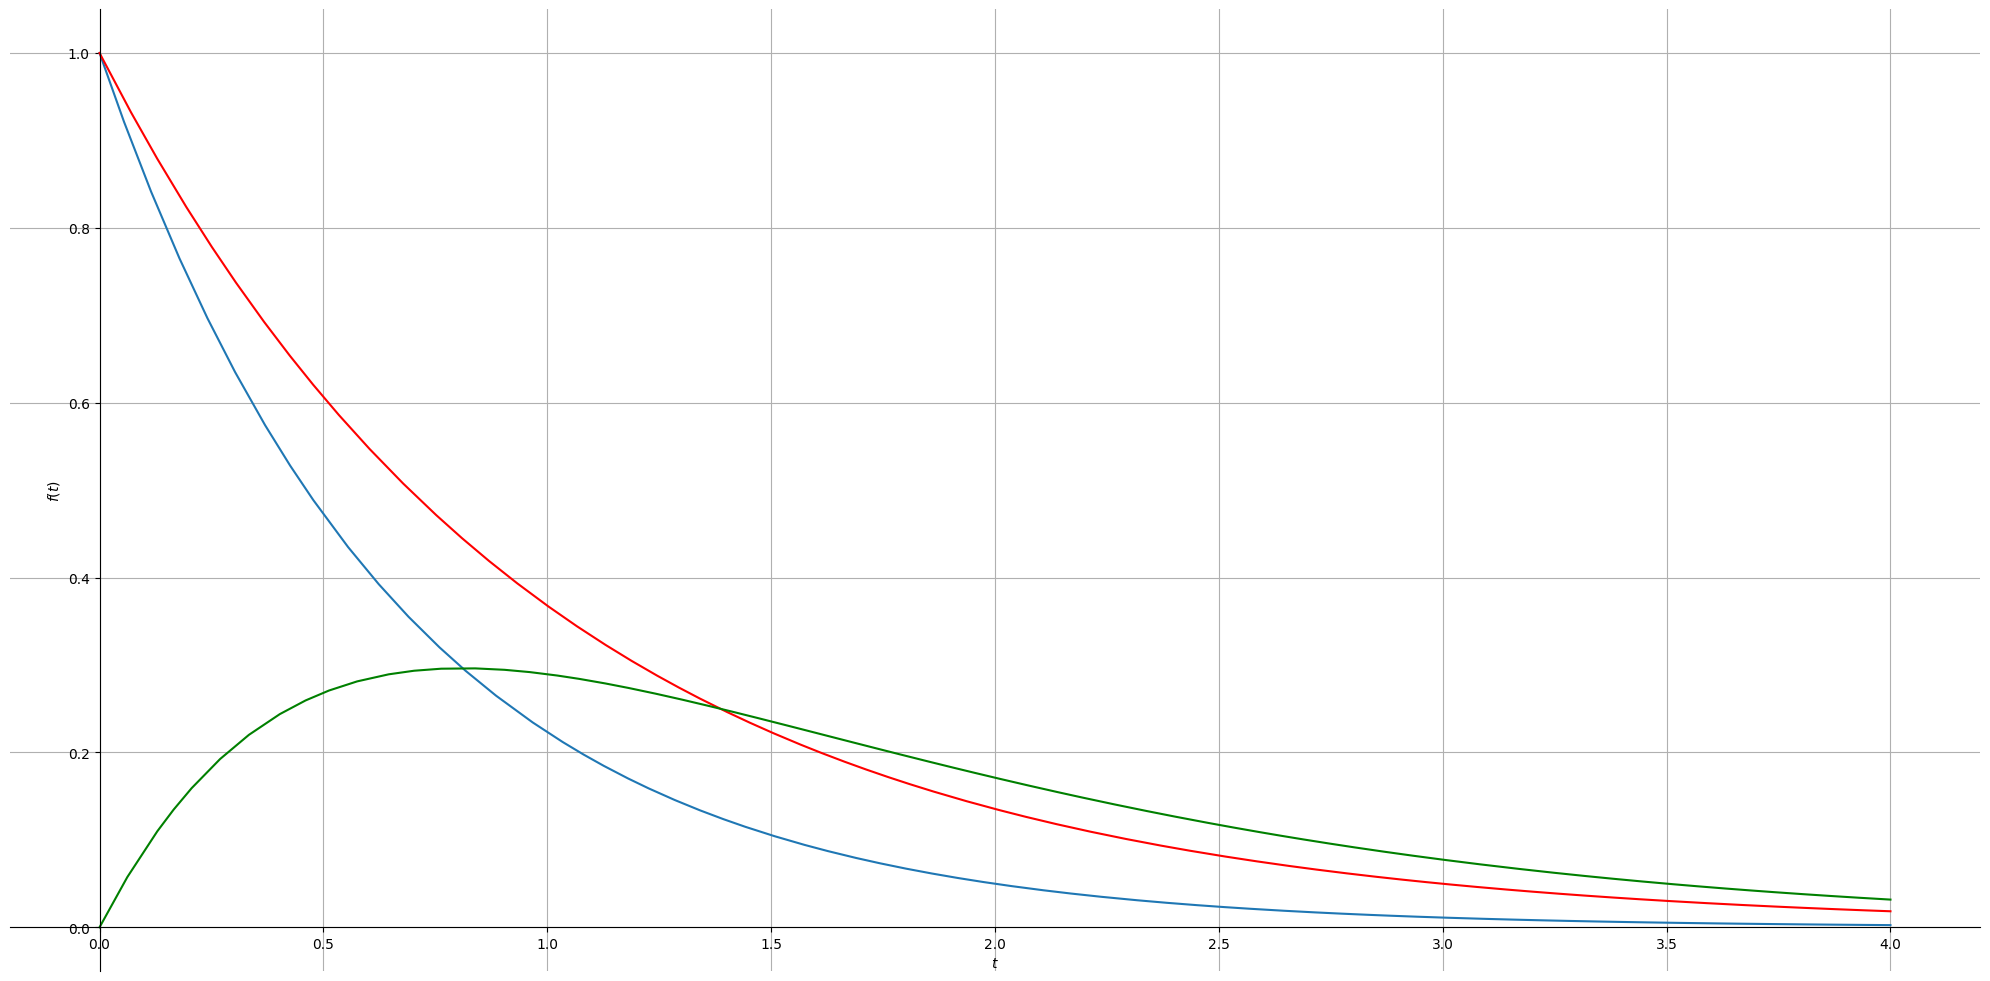

In [19]:
from sympy import oo, Symbol, integrate, exp, Heaviside, plot, sin, cos, Piecewise

def convolve(f, g, t, lower_limit=-oo, upper_limit=oo):
    tau = Symbol('__very_unlikely_name__', real=True)
    return integrate(f.subs(t, tau) * g.subs(t, t - tau), (tau, lower_limit, upper_limit))

t = Symbol('t')
f1 = exp(-1.5*t)
f2 = exp(-1*t)
f3 = convolve(f1, f2, t, 0 ,t)

print(f3)

p1 = plot(f1, (t, 0,4), show=False)
p2 = plot(f2, (t, 0,4), line_color='red', show=False)
p3 = plot(f3, (t, 0,4), line_color='green', show=False)

p1.append(p2[0])
p1.append(p3[0])
p1.show()

In [20]:
gs = 2/3*(1-exp(-1.5*t))
g = gs.diff(t)
g

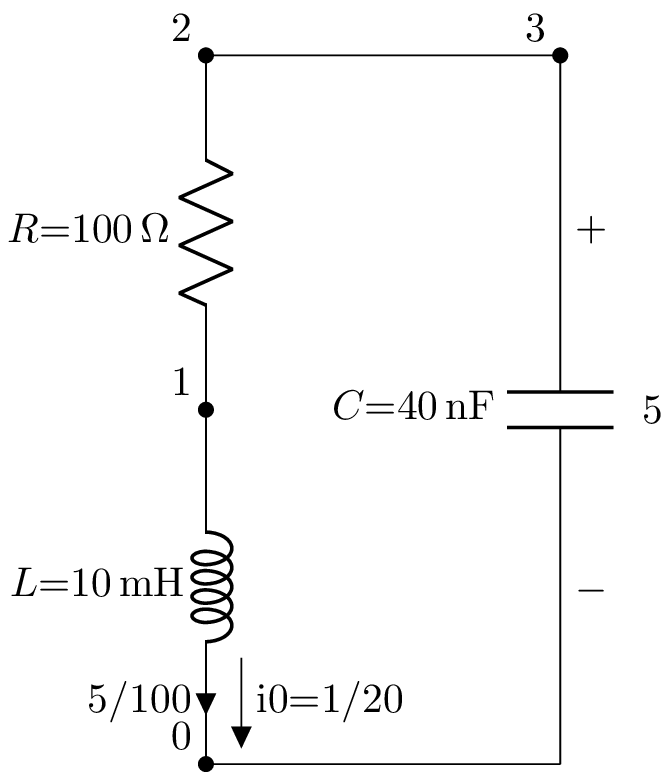

1/20

In [21]:
#from sympy import exp, Heaviside, diff

Vin = 5
RR = 100
CC = 40e-9
LL = 10e-3

cct7 = Circuit("""
L 1 0 L {Iin}; down=1.5, i = 5/100
R 2 1 R ; down=1.5
W 2 3; right=1.5
C 3 0_3 C Vin; down=1.5, v = 5
W 0 0_3; right""")

cct7a = cct7.subs({'Vin':5, 'R': RR, 'C':CC, 'L':LL, 'Iin':Vin/RR})

cct7a.draw()
cct7a.L.i(0)


In [22]:
wn = 1/np.sqrt(LL*CC)
zeta = RR/LL/2/wn
wd = wn*np.sqrt(1-zeta**2)
print('Freq = ',wn,'Damping = ',zeta,'Real =',zeta*wn,'Damped Freq = ',wd)

Freq =  49999.99999999999 Damping =  0.10000000000000002 Real = 5000.0 Damped Freq =  49749.37185533099


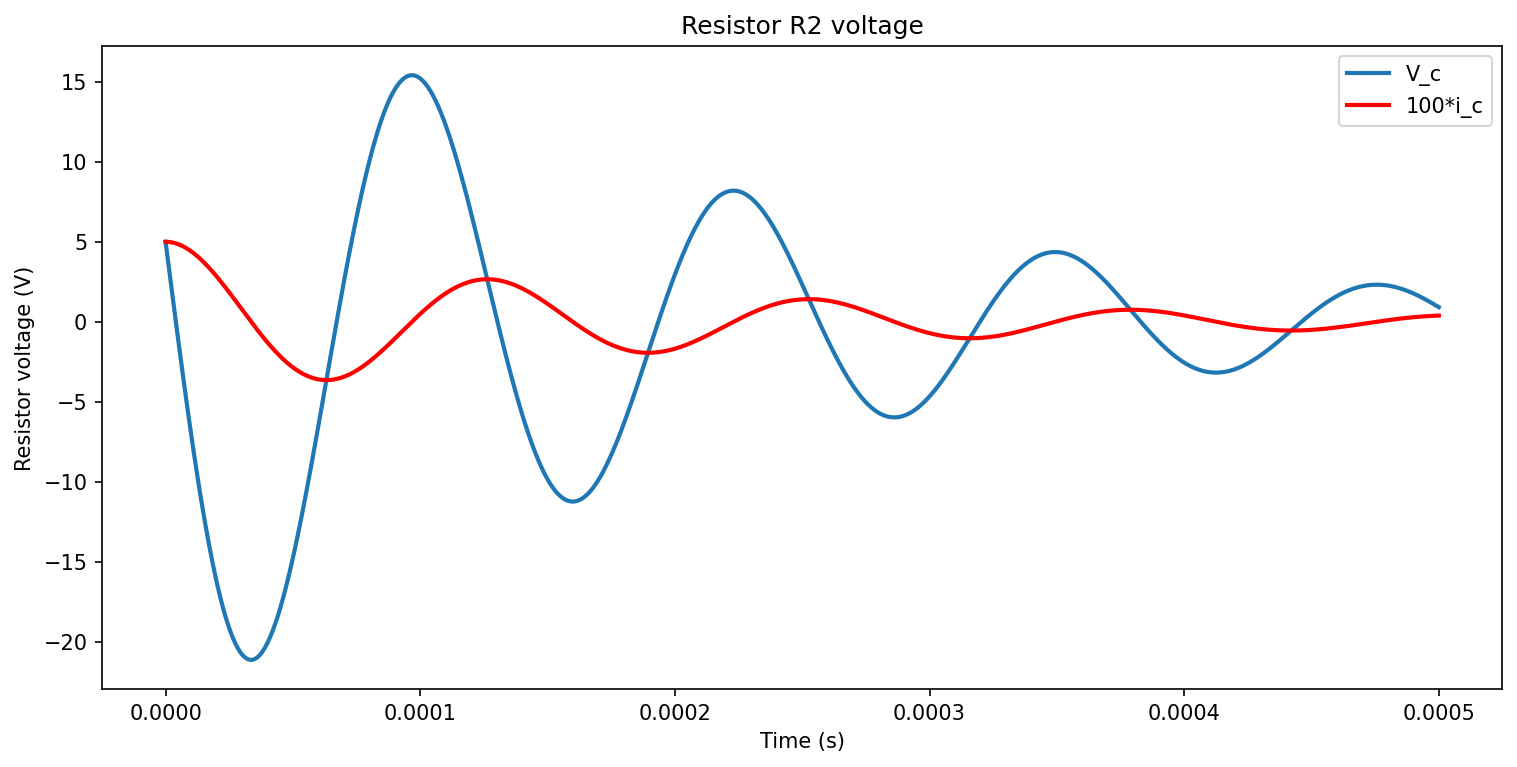

In [23]:
t = np.linspace(0, 5e-4, 1000)
vr = cct7a.C.v.evaluate(t)
vi = 100*cct7a.L.i.evaluate(t)

fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
ax = fig.add_subplot(111, title='Resistor R2 voltage')
ax.plot(t, vr, linewidth=2, label='V_c')
ax.plot(t, vi, linewidth=2, color='red', label='100*i_c')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');
ax.grid()
plt.legend()
plt.show()

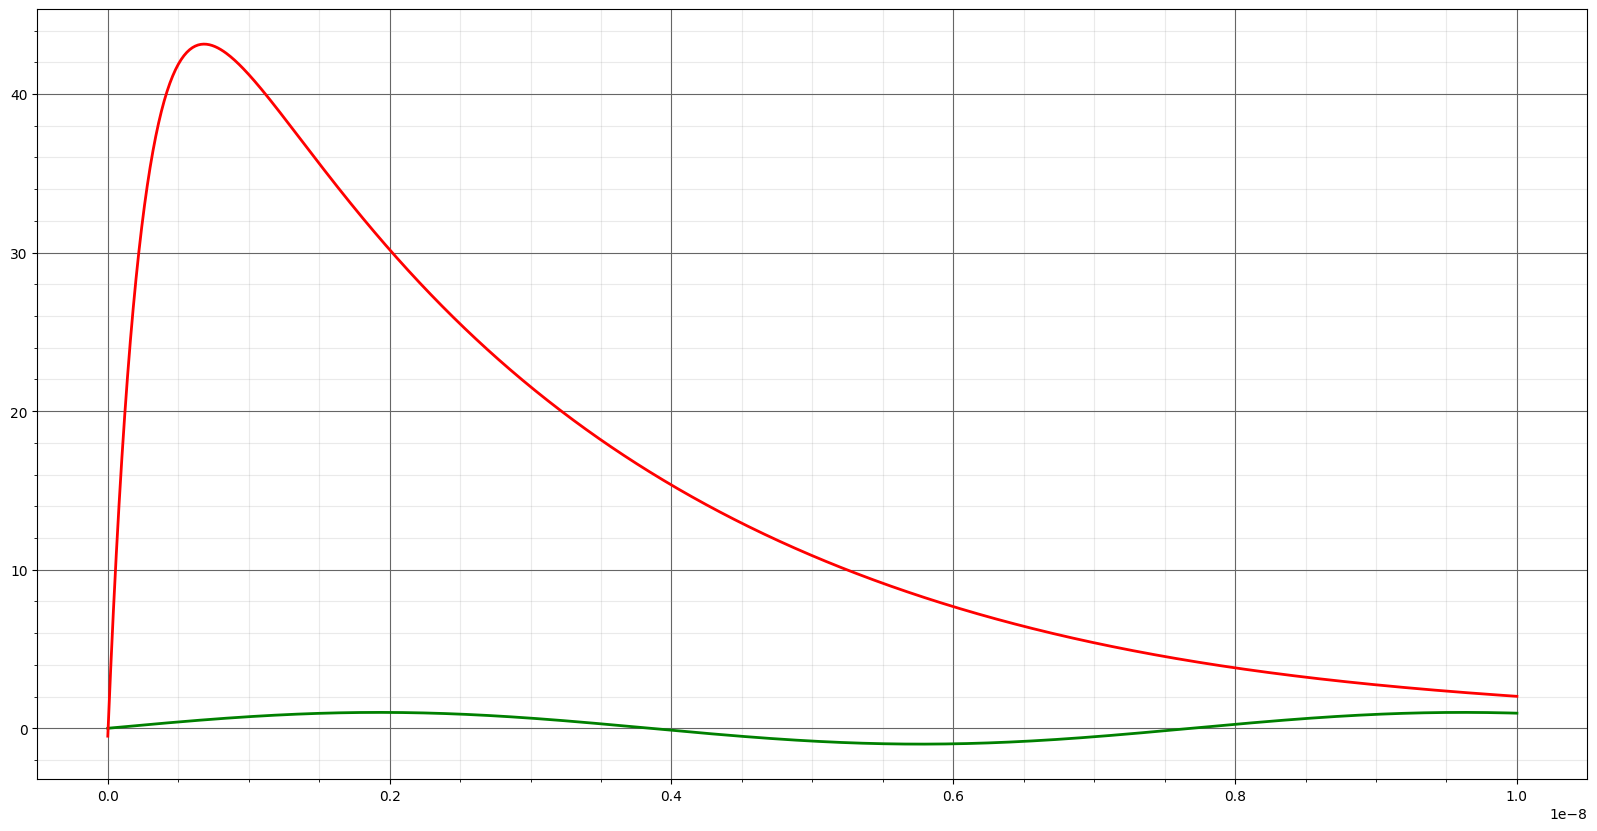

In [24]:
cct = Circuit('''
... Vin 1 0 {sin(130e6*2*3.14159*t)};  
... Rin 1 2; 
... La  2 3 La 1; 
... Rs  3 4;  
... Cs  2 4 Cs 1; 
... Rl  4 0; ''')

cct1 = cct.subs({'Rin': 50, 'Cs':2.34e-12, 'La': 0.32e-6, 'Rs': 0.532, 'Rl': 50})
##H = cct.transfer(1,0,4,0)
##print(H)

t = np.linspace(0, 1e-8, 1000)
Vinp = cct1.Vin.v.evaluate(t)
Vout = cct1.Rl.v.evaluate(t)

plt.plot(t, Vinp, 'g', linewidth=2)
plt.plot(t, Vout, 'r', linewidth=2)
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

# Initialize to act like a switch

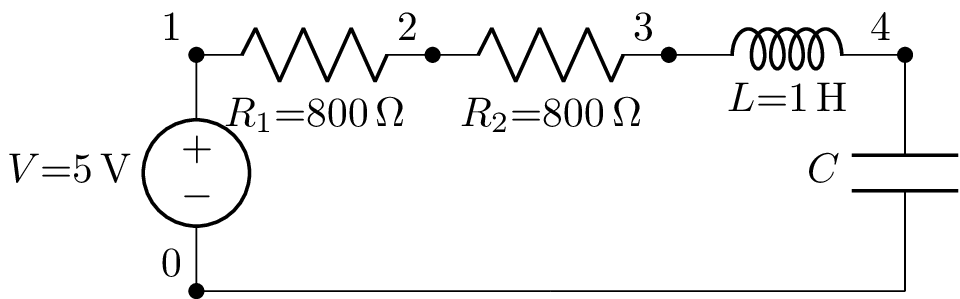

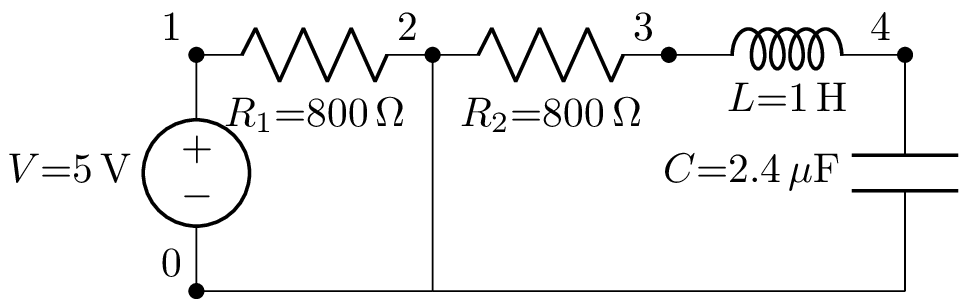

In [25]:
Vin = 5
RR = 100
CC = 40e-9
LL = 10e-3

a1 = Circuit("""
... V 1 0 dc 5; down
... R1 1 2 800; right
... R2 2 3 800; right
... L 3 4 1; right
... W 0 0_2; right
... C 4 0_4 ; down
... W 0_2 0_4; right
""")
a1.draw()

a2 = Circuit("""
... V 1 0 dc 5; down
... R1 1 2 800; right
... R2 2 3 800; right
... L 3 4 1; right
... W 0 0_2; right
... C 4 0_4 0.24e-5; down
... W 0_2 0_4; right
... W 2 0_2; down
""")
a2.draw()

In [26]:
a2i = a2.initialize(a1, 0)

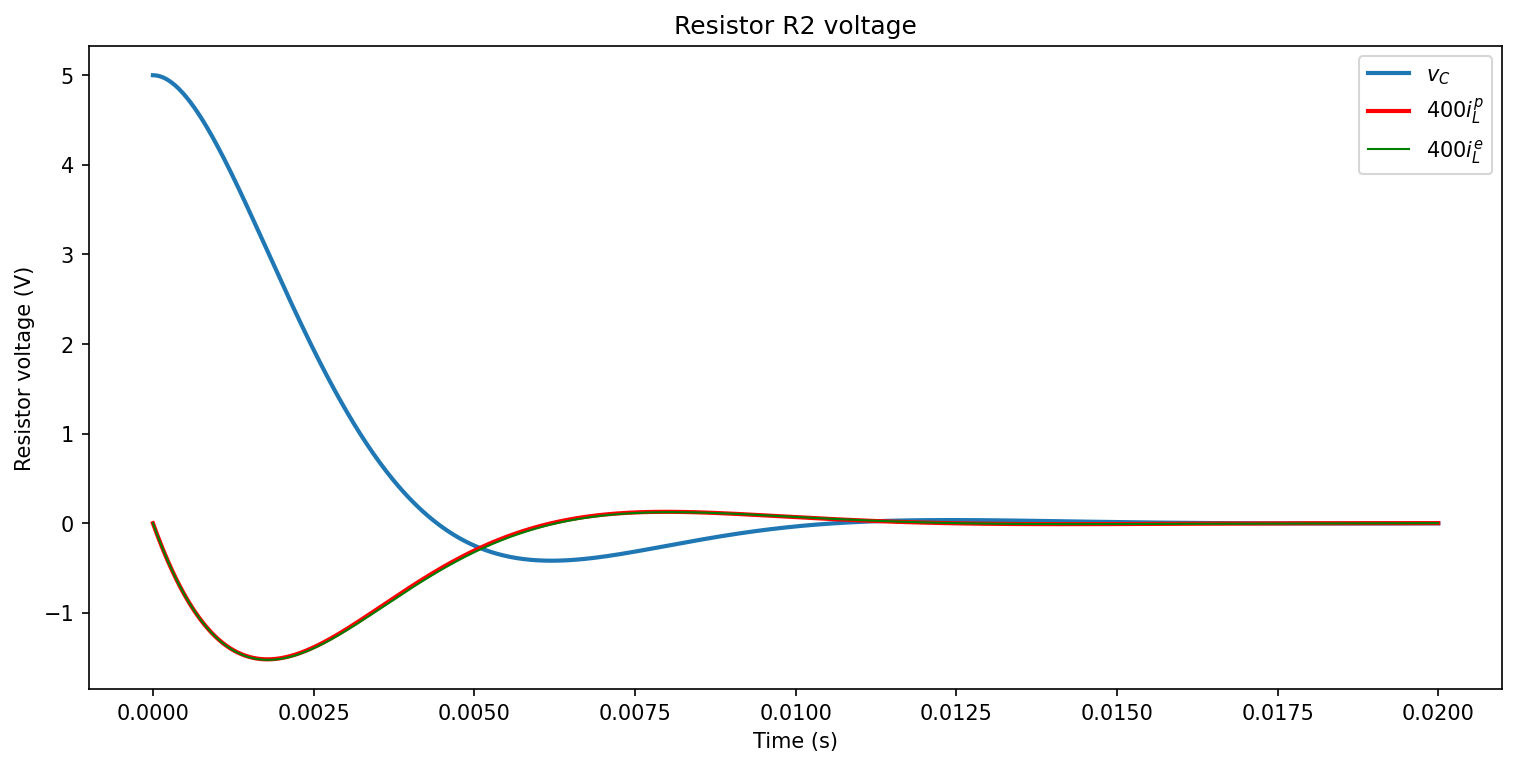

In [27]:
t = np.linspace(0, 2e-2, 1000)
vCr = a2i.C.v.evaluate(t)
vLi = 400*a2i.L.i.evaluate(t)
i_analytic = -0.01*np.exp(-400*(t))*np.sin(500*(t))*np.heaviside(t,0)

fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
ax = fig.add_subplot(111, title='Resistor R2 voltage')
ax.plot(t, vCr, linewidth=2, label='$v_C$')
ax.plot(t, vLi, linewidth=2, color='red', label='$400i_L^p$')
ax.plot(t, i_analytic*400, linewidth=1, color='green', label='$400i_L^e$')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');
ax.grid()
plt.legend()
plt.show()

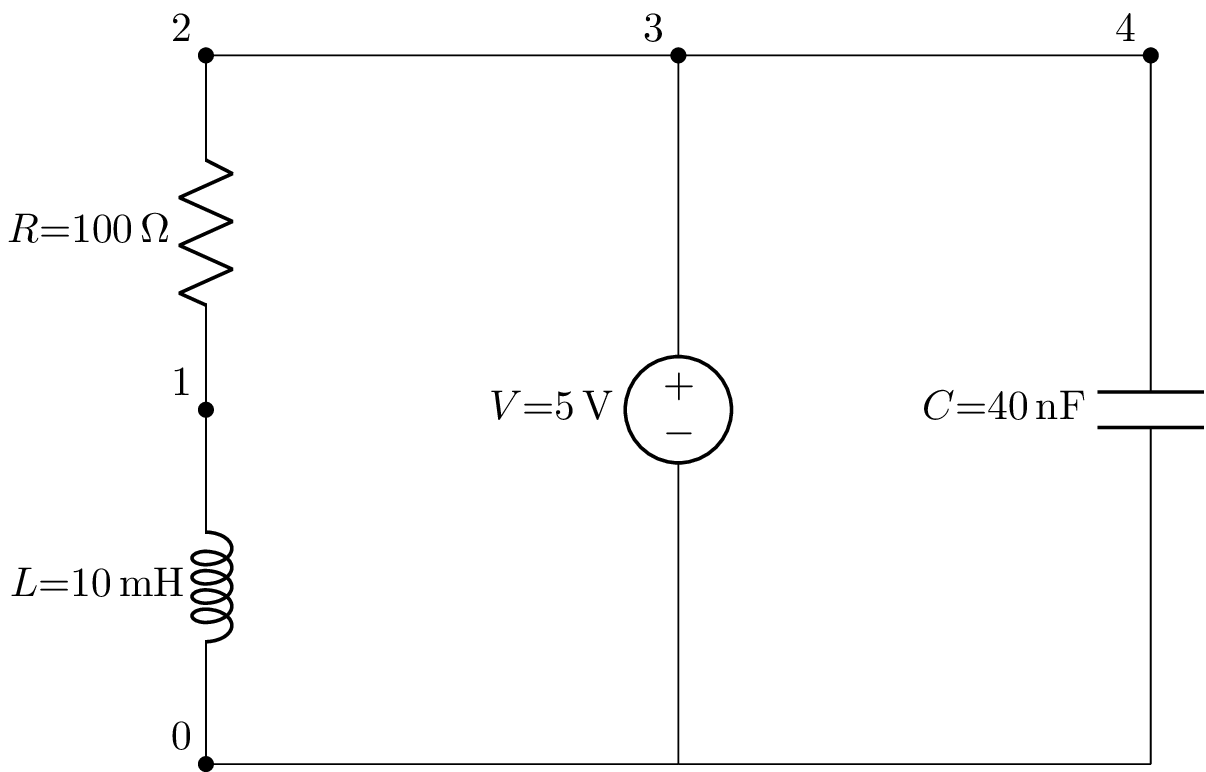

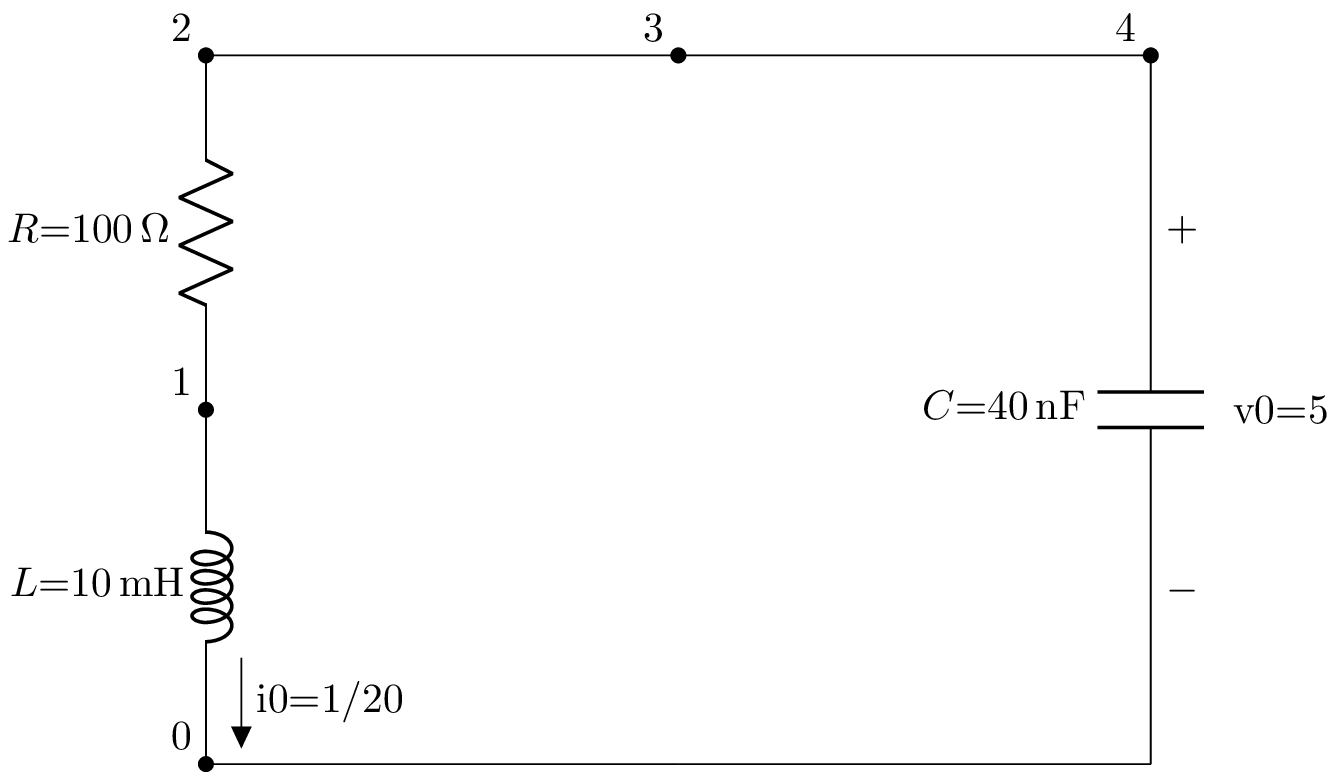

In [28]:
#from sympy import exp, Heaviside, diff

Vin = 5
RR = 100
CC = 40e-9
LL = 10e-3

cct7_0 = Circuit("""
L 1 0 L ; down=1.5
R 2 1 R ; down=1.5
W 2 3; right=2
W 3 4; right=2
V 3 0_3 dc 5; down
C 4 0_4 C; down=1.5 
W 0 0_3; right
W 0_3 0_4; right
""")

cct7_1 = Circuit("""
L 1 0 L ; down=1.5
R 2 1 R ; down=1.5
W 2 3; right=2
W 3 4; right=2
C 4 0_4 C; down=1.5
W 0 0_3; right
W 0_3 0_4; right
""")

cct7_0a = cct7_0.subs({'Vin':5, 'R': RR, 'C':CC, 'L':LL})
cct7_1a = cct7_1.subs({'Vin':5, 'R': RR, 'C':CC, 'L':LL})

cct7_1a = cct7_1a.initialize(cct7_0a, 0)

cct7_0a.draw()
cct7_1a.draw()


Freq =  49999.99999999999 Damping =  0.10000000000000002 Real = 5000.0 Damped Freq =  49749.37185533099


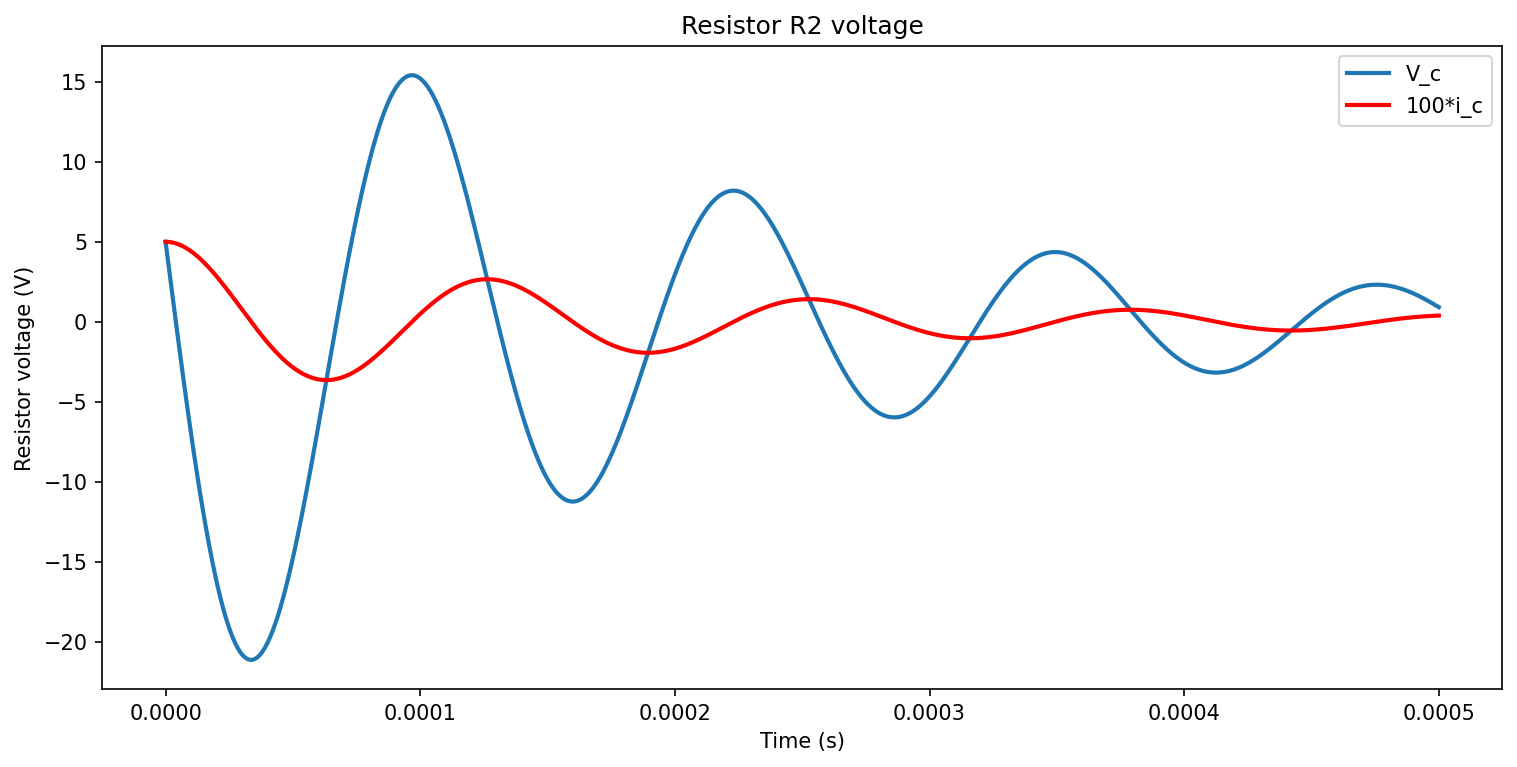

In [29]:
wn = 1/np.sqrt(LL*CC)
zeta = RR/LL/2/wn
wd = wn*np.sqrt(1-zeta**2)
print('Freq = ',wn,'Damping = ',zeta,'Real =',zeta*wn,'Damped Freq = ',wd)

t = np.linspace(0, 5e-4, 1000)
vr = cct7_1a.C.v.evaluate(t)
vi = 100*cct7_1a.L.i.evaluate(t)

fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
ax = fig.add_subplot(111, title='Resistor R2 voltage')
ax.plot(t, vr, linewidth=2, label='V_c')
ax.plot(t, vi, linewidth=2, color='red', label='100*i_c')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');
ax.grid()
plt.legend()
plt.show()

Equivalent Circuit before switch closed at time $t=0$


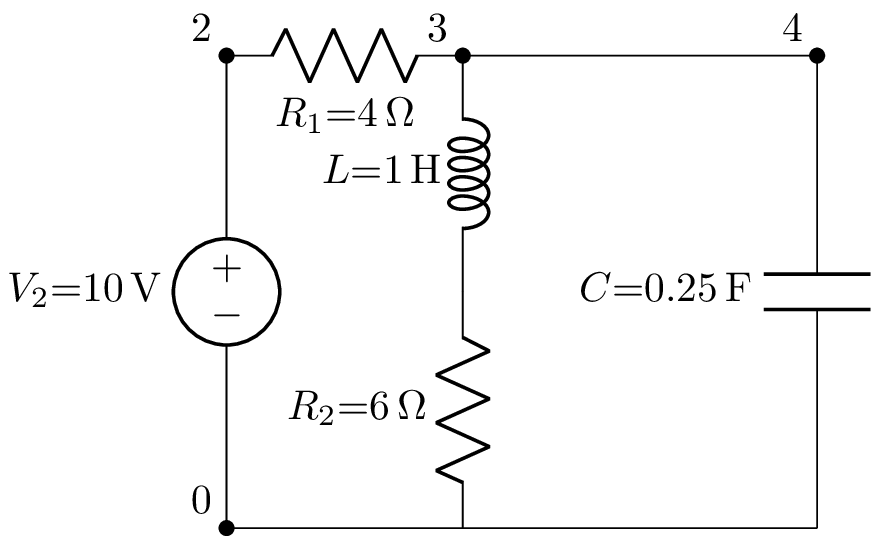

Equivalent Circuit after switch closed at time $t=0$


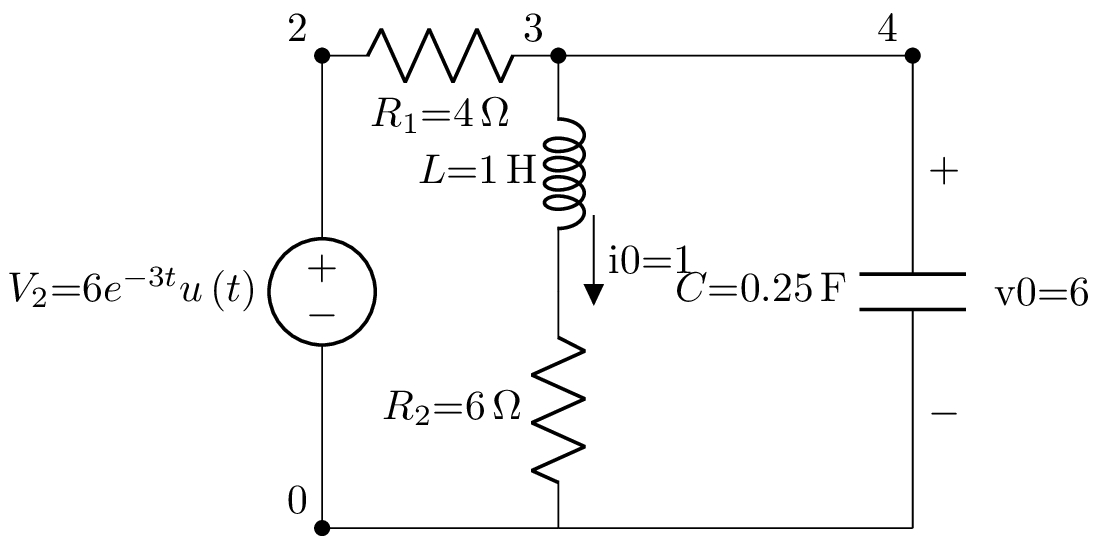

In [30]:
if 1:
    #from sympy import exp, Heaviside, diff

    Vin = 10
    CC = 0.25
    LL = 1

    cct8_0 = Circuit("""
    V2 2 0 dc 10; down
    R1 2 3 4 ; right=1
    L 3 1_3 L ; down=1
    R2 1_3 0_3 6 ; down=1
    W 3 4; right=1.5
    C 4 0_4 C; down=1 
    W 0 0_3; right
    W 0_3 0_4; right
    """)

    cct8_1 = Circuit("""
    V2 2 0 {6*exp(-3*t)*Heaviside(t)}; down
    R1 2 3 4 ; right=1
    L 3 1_3 L ; down=1
    R2 1_3 0_3 6 ; down=1
    W 3 4; right=1.5
    C 4 0_4 C; down=1 
    W 0 0_3; right
    W 0_3 0_4; right
    """)

    cct8_0a = cct8_0.subs({'C':CC, 'L':LL})
    cct8_1a = cct8_1.subs({'C':CC, 'L':LL})

    # switch networks at time 0
    cct8_1a = cct8_1a.initialize(cct8_0a, 0)

    print('Equivalent Circuit before switch closed at time $t=0$')
    cct8_0a.draw()
    print('Equivalent Circuit after switch closed at time $t=0$')
    cct8_1a.draw()

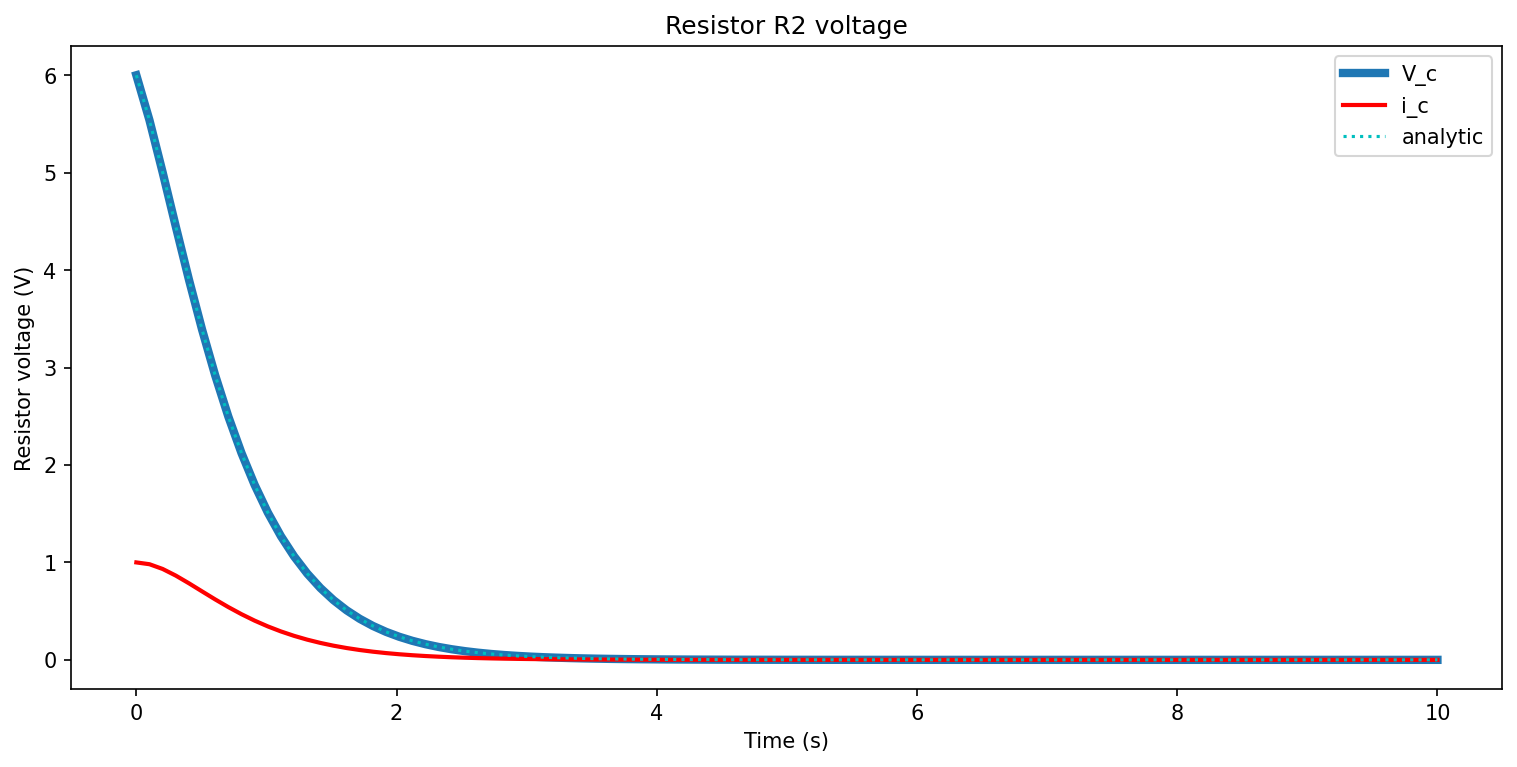

In [31]:
t = np.linspace(0, 10, 100)
vr = cct8_1a.C.v.evaluate(t)
vi = cct8_1a.L.i.evaluate(t)

fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
ax = fig.add_subplot(111, title='Resistor R2 voltage')
ax.plot(t, vr, linewidth=4, label='V_c')
ax.plot(t, vi, linewidth=2, color='red', label='i_c')
ax.plot(t, 44/3*np.exp(-2*t)+np.exp(-5*t)/3-9*np.exp(-3*t), 'c:', label='analytic')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');
ax.grid()
plt.legend()
plt.show()

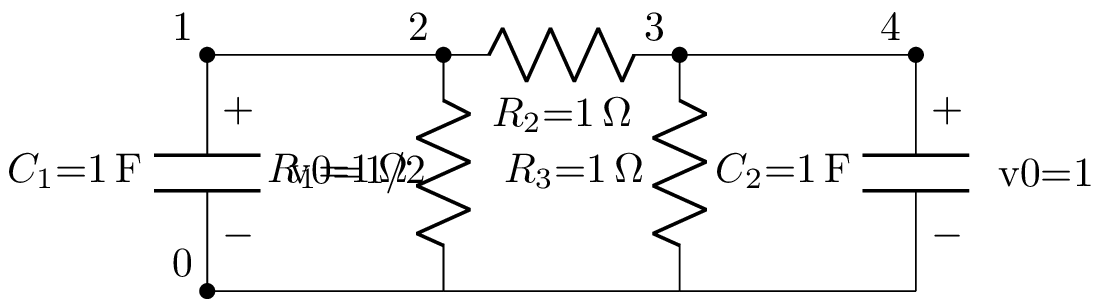

In [32]:
a1 = Circuit("""
... C1 1 0 1 1/2; down
... W 1 2; right
... R1 2 0_2 1; down
... R2 2 3 1; right
... R3 3 0_3 1; down
... W 3 4; right
... C2 4 0_4 1 1; down
... W 0 0_2; right
... W 0_2 0_3; right
... W 0_3 0_4; right
""")
a1.draw()


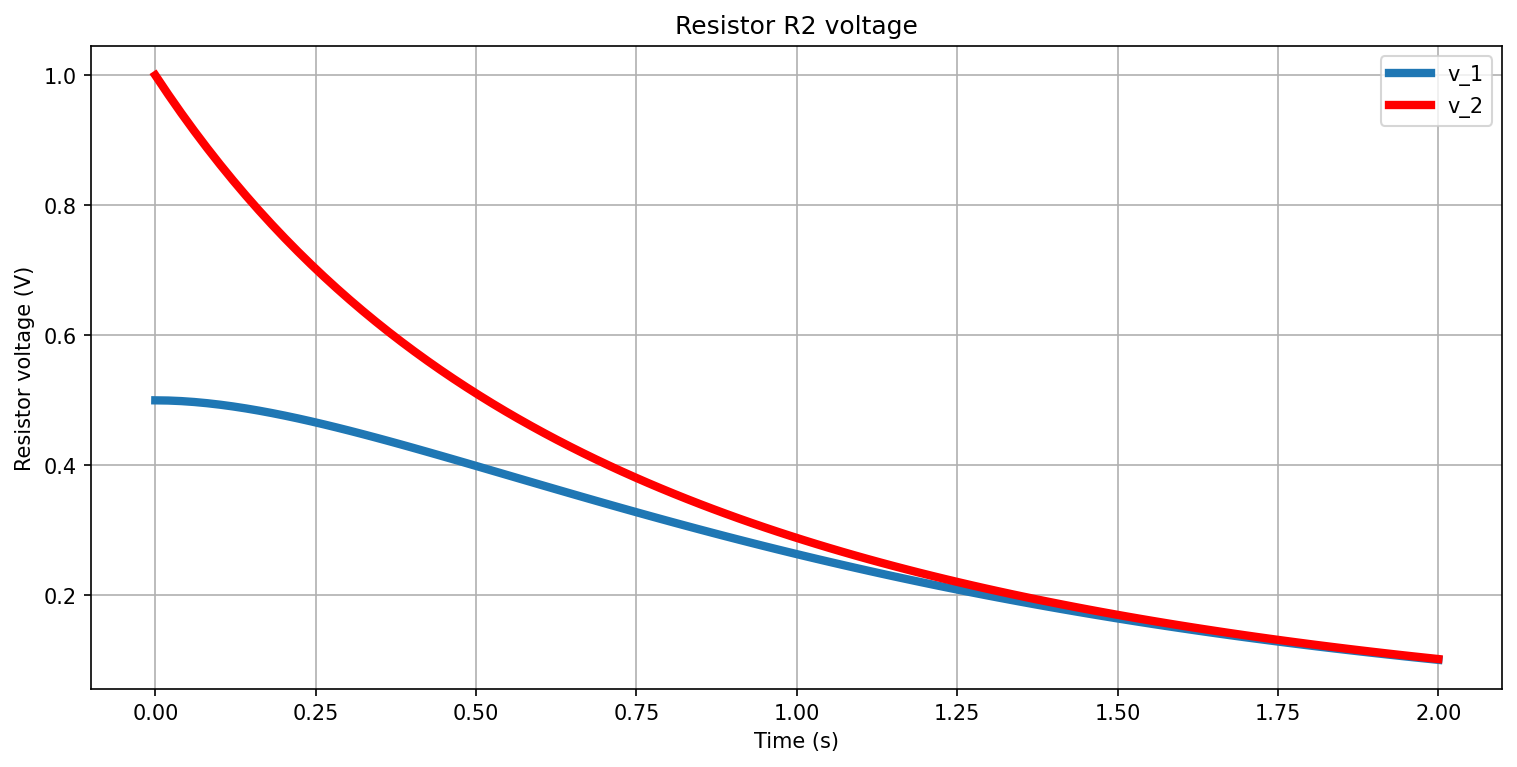

In [33]:
t = np.linspace(0, 2, 100)
v1 = a1.C1.v.evaluate(t)
v2 = a1.C2.v.evaluate(t)

fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
ax = fig.add_subplot(111, title='Resistor R2 voltage')
ax.plot(t, v1, linewidth=4, label='v_1')
ax.plot(t, v2, linewidth=4, color='red', label='v_2')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');
ax.grid(True)
plt.legend()
plt.show()